<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Diffusion-equation" data-toc-modified-id="Diffusion-equation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Diffusion equation</a></span></li><li><span><a href="#implementations" data-toc-modified-id="implementations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>implementations</a></span><ul class="toc-item"><li><span><a href="#Environment" data-toc-modified-id="Environment-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Environment</a></span></li><li><span><a href="#Python:-list[]" data-toc-modified-id="Python:-list[]-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Python: <code>list[]</code></a></span></li><li><span><a href="#Python:-ndarray[]" data-toc-modified-id="Python:-ndarray[]-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Python: <code>ndarray[]</code></a></span></li><li><span><a href="#Numpy" data-toc-modified-id="Numpy-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Numpy</a></span></li><li><span><a href="#Numba" data-toc-modified-id="Numba-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Numba</a></span></li><li><span><a href="#Cython:-exact-python" data-toc-modified-id="Cython:-exact-python-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Cython: exact python</a></span></li><li><span><a href="#Cython:-with-type-annotation" data-toc-modified-id="Cython:-with-type-annotation-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Cython: with type annotation</a></span></li><li><span><a href="#Cython:-optimized-for-strides" data-toc-modified-id="Cython:-optimized-for-strides-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Cython: optimized for strides</a></span></li><li><span><a href="#Cython:-C" data-toc-modified-id="Cython:-C-2.9"><span class="toc-item-num">2.9&nbsp;&nbsp;</span>Cython: C</a></span></li><li><span><a href="#C/C++" data-toc-modified-id="C/C++-2.10"><span class="toc-item-num">2.10&nbsp;&nbsp;</span>C/C++</a></span></li><li><span><a href="#Test-the-correctness" data-toc-modified-id="Test-the-correctness-2.11"><span class="toc-item-num">2.11&nbsp;&nbsp;</span>Test the correctness</a></span></li></ul></li><li><span><a href="#Have-a-break:-Visualization-of-the-temperature" data-toc-modified-id="Have-a-break:-Visualization-of-the-temperature-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Have a break: Visualization of the temperature</a></span></li><li><span><a href="#Test-speed" data-toc-modified-id="Test-speed-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test speed</a></span><ul class="toc-item"><li><span><a href="#Discussion" data-toc-modified-id="Discussion-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Discussion</a></span><ul class="toc-item"><li><span><a href="#CPython" data-toc-modified-id="CPython-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>CPython</a></span></li><li><span><a href="#numpy" data-toc-modified-id="numpy-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>numpy</a></span></li><li><span><a href="#Cython" data-toc-modified-id="Cython-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>Cython</a></span></li><li><span><a href="#numba" data-toc-modified-id="numba-4.1.4"><span class="toc-item-num">4.1.4&nbsp;&nbsp;</span>numba</a></span></li></ul></li></ul></li><li><span><a href="#Some-optimization" data-toc-modified-id="Some-optimization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Some optimization</a></span><ul class="toc-item"><li><span><a href="#Pingpong" data-toc-modified-id="Pingpong-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Pingpong</a></span></li><li><span><a href="#Backup-one-line" data-toc-modified-id="Backup-one-line-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Backup one line</a></span></li><li><span><a href="#An-in-equivalent-algorithm" data-toc-modified-id="An-in-equivalent-algorithm-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>An in-equivalent algorithm</a></span></li></ul></li></ul></div>

# Diffusion equation

Stationary diffusion equation
$$\frac{\partial^2 \phi}{\partial^2 x} + \frac{\partial^2 \phi}{\partial^2 y} = -4\rho$$
where the $\rho$ is the source, $\phi$ is the density.

In the heat transfer example, the heat source is the source, and the temperature is the "heat density".

We can descrese the equation as
$$
\frac{\phi(x+\Delta x,y) + \phi(x-\Delta x,y) + \phi(x,y+\Delta x) + \phi(x,y-\Delta x) - 4\phi(x,y)}{(\Delta x) ^2} =  -4\rho
$$
where $\Delta x = \Delta y$
Then we can write down the iteration equation
$$
\phi(x,y) = \frac{\phi(x+\Delta x,y) + \phi(x-\Delta x,y) + \phi(x,y+\Delta x) + \phi(x,y-\Delta x)}{4} + (\Delta x) ^2 \rho
$$

# implementations

## Environment

In [1]:
import sys
print(sys.version)

3.6.7 |Anaconda, Inc.| (default, Dec 10 2018, 20:35:02) [MSC v.1915 64 bit (AMD64)]


In [2]:
import numpy as np
def test_speed(solver, n_updates=1000, array="ndarray"):

    print("benchmarking: %s" % solver.__name__)
    ns = 10**np.linspace(1.5, 3, 10)
    ans = []

    for n_float in ns:

        n = int(n_float)
        rho = np.zeros((n, n), dtype=np.float64)
        phi = np.zeros((n, n), dtype=np.float64)

        if array == "ndarray":
            t=%timeit -q -r3 -o solver(phi, rho, 1, 0.1, n_updates)
        else:
            phi = phi.tolist()
            rho = rho.tolist()
            t=%timeit -q -r3 -o solver(phi, rho, 1, 0.1, n_updates)

        ans.append(t)

        time = t.average
        print("Average (%5d loops) time of %10.4f s for %4d updates on grid of %dx%d" %
              (t.loops, float(time), n_updates, int(n), int(n)))

    return ans

## Python: `list[]`

In [3]:
#%%writefile temp_list.py

import copy

def temperature_python_list(phi, rho, alpha, dx, n_iter):
    # phi[0,:] the left boundary, not update
    # phi[phi.shape[0]-1,:] the right boundary, not update
    # phi[0,:] the left boundary, not update
    # phi[:,phi.shape[1]-1] the top boundary, not update

    # a buffer is needed
    # we don't want to refer the updated result
    # when we write e.g. phi[i-1,j]
    phi_update = copy.deepcopy(phi)
    M = len(phi)
    N = len(phi[0])
    for it in range(n_iter):
        for i in range(1, M - 1):
            for j in range(1, N - 1):
                phi_update[i][j] = 0.25 * (phi[i - 1][j] + phi[i + 1][j]\
                    + phi[i][j - 1] + phi[i][j + 1])\
                    + dx*dx * rho[i][j]

        for i in range(1, M - 1):
            for j in range(1, N - 1):
                phi[i][j] = phi_update[i][j]

In [4]:
t_python_list=test_speed(temperature_python_list, n_updates=1, array="list")

benchmarking: temperature_python_list
Average ( 1000 loops) time of     0.0009 s for    1 updates on grid of 31x31
Average ( 1000 loops) time of     0.0019 s for    1 updates on grid of 46x46
Average (  100 loops) time of     0.0042 s for    1 updates on grid of 68x68
Average (  100 loops) time of     0.0090 s for    1 updates on grid of 100x100
Average (  100 loops) time of     0.0193 s for    1 updates on grid of 146x146
Average (   10 loops) time of     0.0419 s for    1 updates on grid of 215x215
Average (   10 loops) time of     0.0920 s for    1 updates on grid of 316x316
Average (    1 loops) time of     0.2048 s for    1 updates on grid of 464x464
Average (    1 loops) time of     0.4512 s for    1 updates on grid of 681x681
Average (    1 loops) time of     0.9893 s for    1 updates on grid of 1000x1000


## Python: `ndarray[]`

In [5]:
#%%writefile temp.py
import numpy as np


def temperature_python(phi, rho, alpha, dx, n_iter):
    # phi[0,:] the left boundary, not update
    # phi[phi.shape[0]-1,:] the right boundary, not update
    # phi[0,:] the left boundary, not update
    # phi[:,phi.shape[1]-1] the top boundary, not update

    # a buffer is needed
    # we don't want to refer the updated result
    # when we write e.g. phi[i-1,j]
    phi_update = np.empty_like(phi)
    for it in range(n_iter):
        for i in range(1, phi.shape[0] - 1):
            for j in range(1, phi.shape[1] - 1):
                phi_update[i, j] = 0.25 * (phi[i - 1,j] + phi[i + 1,j]\
                    + phi[i, j - 1] + phi[i, j + 1])\
                    + dx*dx * rho[i, j]

        for i in range(1, phi.shape[0] - 1):
            for j in range(1, phi.shape[1] - 1):
                phi[i, j] = phi_update[i, j]

In [6]:
t_python_ndarray=test_speed(temperature_python, n_updates=1)

benchmarking: temperature_python
Average ( 1000 loops) time of     0.0015 s for    1 updates on grid of 31x31
Average (  100 loops) time of     0.0035 s for    1 updates on grid of 46x46
Average (  100 loops) time of     0.0078 s for    1 updates on grid of 68x68
Average (  100 loops) time of     0.0171 s for    1 updates on grid of 100x100
Average (   10 loops) time of     0.0370 s for    1 updates on grid of 146x146
Average (   10 loops) time of     0.0807 s for    1 updates on grid of 215x215
Average (   10 loops) time of     0.1772 s for    1 updates on grid of 316x316
Average (    1 loops) time of     0.4068 s for    1 updates on grid of 464x464
Average (    1 loops) time of     0.8633 s for    1 updates on grid of 681x681
Average (    1 loops) time of     1.8699 s for    1 updates on grid of 1000x1000


## Numpy

In [7]:
def temperature_numpy(phi, rho, alpha, dx, n_iter):

    M = phi.shape[0]
    N = phi.shape[1]
    rho = dx**2 * rho[1:M - 1, 1:N - 1]
    for _ in range(n_iter):
        phi[1:M - 1, 1:N - 1] = 0.25*(phi[0:M - 2, 1:N - 1]\
            + phi[2:M, 1:N - 1]\
            + phi[1:M-1, 0:N - 2]\
            + phi[1:M-1, 2:N])\
            + rho

In [8]:
t_numpy=test_speed(temperature_numpy)

benchmarking: temperature_numpy
Average (  100 loops) time of     0.0119 s for 1000 updates on grid of 31x31
Average (  100 loops) time of     0.0160 s for 1000 updates on grid of 46x46
Average (   10 loops) time of     0.0285 s for 1000 updates on grid of 68x68
Average (   10 loops) time of     0.0480 s for 1000 updates on grid of 100x100
Average (   10 loops) time of     0.0855 s for 1000 updates on grid of 146x146
Average (   10 loops) time of     0.1713 s for 1000 updates on grid of 215x215
Average (    1 loops) time of     0.3376 s for 1000 updates on grid of 316x316
Average (    1 loops) time of     2.6493 s for 1000 updates on grid of 464x464
Average (    1 loops) time of     6.5440 s for 1000 updates on grid of 681x681
Average (    1 loops) time of    15.4005 s for 1000 updates on grid of 1000x1000


## Numba

In [9]:
import numba as nb
#parallel=True not work in this case
temperature_numba = nb.jit(nopython=True)(temperature_python)
temperature_numba_numpy = nb.jit(nopython=True)(temperature_numpy)

In [10]:
t_numba=test_speed(temperature_numba)
t_numba_numpy=test_speed(temperature_numba_numpy)

benchmarking: temperature_python
Average (    1 loops) time of     0.0009 s for 1000 updates on grid of 31x31
Average ( 1000 loops) time of     0.0019 s for 1000 updates on grid of 46x46
Average (  100 loops) time of     0.0034 s for 1000 updates on grid of 68x68
Average (  100 loops) time of     0.0072 s for 1000 updates on grid of 100x100
Average (  100 loops) time of     0.0177 s for 1000 updates on grid of 146x146
Average (   10 loops) time of     0.0362 s for 1000 updates on grid of 215x215
Average (   10 loops) time of     0.0782 s for 1000 updates on grid of 316x316
Average (    1 loops) time of     0.2111 s for 1000 updates on grid of 464x464
Average (    1 loops) time of     0.7326 s for 1000 updates on grid of 681x681
Average (    1 loops) time of     2.0023 s for 1000 updates on grid of 1000x1000
benchmarking: temperature_numpy
Average (    1 loops) time of     0.0051 s for 1000 updates on grid of 31x31
Average (  100 loops) time of     0.0114 s for 1000 updates on grid of 4

## Cython: exact python

In [11]:
# please install cython
# >>> conda install cython
%load_ext cython

We compile the python to C code. The only optimization is avoiding the reading the bytecode and parsing. Because, in this mode, we still use CPython runtime and the CPython runtime is the slowest part. We except there is no acceleration.

In [12]:
%%cython
#%load temp.py
import numpy as np

def temperature_cython_python(phi, rho, alpha, dx, n_iter):
    # phi[0,:] the left boundary, not update
    # phi[phi.shape[0]-1,:] the right boundary, not update
    # phi[0,:] the left boundary, not update
    # phi[:,phi.shape[1]-1] the top boundary, not update
    
    # a buffer is needed
    # we don't want to refer the updated result
    # when we write e.g. phi[i-1,j]
    phi_update = np.empty_like(phi)
    for it in range(n_iter):
        for i in range(1, phi.shape[0] - 1):
            for j in range(1, phi.shape[1] - 1):
                phi_update[i, j] = 0.25 * (phi[i - 1,j] + phi[i + 1,j]\
                    + phi[i, j - 1] + phi[i, j + 1])\
                    + dx**2 * rho[i, j]

        for i in range(1, phi.shape[0] - 1):
            for j in range(1, phi.shape[1] - 1):
                phi[i, j] = phi_update[i, j]

In [13]:
t_cython_python=test_speed(temperature_cython_python,n_updates=1)

benchmarking: temperature_cython_python
Average ( 1000 loops) time of     0.0013 s for    1 updates on grid of 31x31
Average (  100 loops) time of     0.0031 s for    1 updates on grid of 46x46
Average (  100 loops) time of     0.0071 s for    1 updates on grid of 68x68
Average (  100 loops) time of     0.0157 s for    1 updates on grid of 100x100
Average (   10 loops) time of     0.0338 s for    1 updates on grid of 146x146
Average (   10 loops) time of     0.0737 s for    1 updates on grid of 215x215
Average (   10 loops) time of     0.1625 s for    1 updates on grid of 316x316
Average (    1 loops) time of     0.3451 s for    1 updates on grid of 464x464
Average (    1 loops) time of     0.7489 s for    1 updates on grid of 681x681
Average (    1 loops) time of     1.6727 s for    1 updates on grid of 1000x1000


## Cython: with type annotation

Cypton is new to me. I hope writing this simple example doesn't require a Cython expert. However, it seems not the case. I looked into the generated c code (via `cython -a`). The generated code doesn't assume the strides to be 1. The code even uses a function to calculate the address from indices. I don't how much the calculation will effect.

In [14]:
%%cython
import numpy as np
cimport numpy as np
cimport cython


@cython.boundscheck(False)
@cython.wraparound(False)
def temperature_cython_typed(np.ndarray[np.float64_t, ndim=2, mode="c"] phi,
                             np.ndarray[np.float64_t, ndim=2, mode="c"] rho,
                             double alpha, double dx,int n_iter):
    
    cdef np.ndarray[np.float64_t, ndim=2, mode="c"] phi_update = np.empty_like(phi)
    cdef int M = phi.shape[0]
    cdef int N = phi.shape[1]
    cdef int i = 0
    cdef int j = 0
            
    for it in range(n_iter):
        for i in range(1, M-1):
            for j in range(1, N-1):
                phi_update[i, j] = 0.25 * (phi[i - 1, j] + phi[i + 1,j]\
                    + phi[i, j - 1] + phi[i, j + 1])\
                    + dx**2 * rho[i, j]

        for i in range(1, M-1):
            for j in range(1, N-1):     
                phi[i,j] = phi_update[i,j]
                

In [15]:
t_cython_typed=test_speed(temperature_cython_typed)

benchmarking: temperature_cython_typed
Average (  100 loops) time of     0.0032 s for 1000 updates on grid of 31x31
Average (  100 loops) time of     0.0065 s for 1000 updates on grid of 46x46
Average (  100 loops) time of     0.0126 s for 1000 updates on grid of 68x68
Average (   10 loops) time of     0.0246 s for 1000 updates on grid of 100x100
Average (   10 loops) time of     0.0499 s for 1000 updates on grid of 146x146
Average (   10 loops) time of     0.1034 s for 1000 updates on grid of 215x215
Average (    1 loops) time of     0.2206 s for 1000 updates on grid of 316x316
Average (    1 loops) time of     0.5129 s for 1000 updates on grid of 464x464
Average (    1 loops) time of     1.1999 s for 1000 updates on grid of 681x681
Average (    1 loops) time of     2.8026 s for 1000 updates on grid of 1000x1000


## Cython: optimized for strides

Now, I tell the cython, the array is indeed a continuous `c` array. The function call for the calculation of index is avoid now.

In [16]:
%%cython
import numpy as np
cimport numpy as np
cimport cython


@cython.boundscheck(False)
@cython.wraparound(False)
def temperature_cython_optimized(np.ndarray[np.float64_t, ndim=2, mode="c"] phi_,
                             np.ndarray[np.float64_t, ndim=2, mode="c"] rho_,
                             double alpha, double dx,int n_iter):
    
    cdef np.ndarray[np.float64_t, ndim=2, mode="c"] phi_update_ = np.empty_like(phi_)    
    cdef int M = phi_.shape[0]
    cdef int N = phi_.shape[1]
    cdef int i = 0
    cdef int j = 0
    
    #####################
    # we assume it is continious c array
    #####################
    
    cdef double[:,::1] phi = phi_
    cdef double[:,::1] rho = rho_
    cdef double[:,::1] phi_update = phi_update_
            
    for it in range(n_iter):
        for i in range(1, M-1):
            for j in range(1, N-1):
                phi_update[i, j] = 0.25 * (phi[i - 1, j] + phi[i + 1,j]\
                    + phi[i, j - 1] + phi[i, j + 1])\
                    + dx**2 * rho[i, j]

        for i in range(1, M-1):
            for j in range(1, N-1):     
                phi[i,j] = phi_update[i,j]
                

In [17]:
t_cython_optimized=test_speed(temperature_cython_optimized)

benchmarking: temperature_cython_optimized
Average (  100 loops) time of     0.0024 s for 1000 updates on grid of 31x31
Average (  100 loops) time of     0.0049 s for 1000 updates on grid of 46x46
Average (  100 loops) time of     0.0088 s for 1000 updates on grid of 68x68
Average (  100 loops) time of     0.0177 s for 1000 updates on grid of 100x100
Average (   10 loops) time of     0.0354 s for 1000 updates on grid of 146x146
Average (   10 loops) time of     0.0723 s for 1000 updates on grid of 215x215
Average (   10 loops) time of     0.1512 s for 1000 updates on grid of 316x316
Average (    1 loops) time of     0.3408 s for 1000 updates on grid of 464x464
Average (    1 loops) time of     0.9169 s for 1000 updates on grid of 681x681
Average (    1 loops) time of     2.2813 s for 1000 updates on grid of 1000x1000


## Cython: C

In [18]:
%%writefile temperature_c.c

#define INDEX(i,j) ((i)*N + (j))

void temperature_c(double * phi, double *phi_update, double * rho,
    int M, int N, double alpha, double dx, int n_iter) {

    // We will not reuse INDEX(i, j)
    // test the compiler!

    for (int it = 0; it < n_iter; ++it) {
        for (int i = 1; i < M - 1; ++i) {
            for (int j = 1; j < N - 1; ++j) {
                phi_update[INDEX(i, j)] = 0.25*(phi[INDEX(i, j - 1)] + phi[INDEX(i, j + 1)]
                    + phi[INDEX(i - 1, j)] + phi[INDEX(i + 1, j)]) + dx * dx*rho[INDEX(i, j)];
            }
        }
        for (int i = 1; i < M - 1; ++i) {
            for (int j = 1; j < N - 1; ++j) {
                phi[INDEX(i, j)] = phi_update[INDEX(i, j)];
            }
        }
    }
}


Overwriting temperature_c.c


Copy file to the directory that contains `*.pyx`. So the compiler can find our C code.

In [19]:
import os.path, shutil
from sys import platform

if platform == "linux" or platform == "linux2":
    # linux
    pyx_dir=os.path.join(os.path.expanduser('~'), ".cache/ipython/cython/")
    shutil.copy("temperature_c.c", pyx_dir)
elif platform == "darwin":
    # OS X
    # I don't have mac ...
    # Try fix this by yourself
    pass
elif platform == "win32":
    # Windows...
    pyx_dir=os.path.join(os.path.expanduser('~'), ".ipython\cython")
    shutil.copy("temperature_c.c", pyx_dir)

In the '.pyx' part, we transform `ndarray` to C pointer, then call the temperature_c.

In [20]:
%%cython

import numpy as np
cimport numpy as np
cimport cython

cdef extern from "temperature_c.c":
    # C is include here so that it doesn't need to be compiled externally
    pass

cdef extern void temperature_c(double *,double *,double *rho, int, int, double, double, int)

@cython.boundscheck(False)
@cython.wraparound(False)
def temperature_cython_c(np.ndarray[np.float64_t, ndim=2, mode="c"] phi_,
                             np.ndarray[np.float64_t, ndim=2, mode="c"] rho_,
                             double alpha, double dx,int n_iter):
    
    cdef np.ndarray[np.float64_t, ndim=2, mode="c"] phi_update_ = np.empty_like(phi_)    
    cdef int M = phi_.shape[0]
    cdef int N = phi_.shape[1]
    cdef int i = 0
    cdef int j = 0
    
    #####################
    # we assume it is continious c array
    #####################
    
    cdef double[:,::1] phi = phi_
    cdef double[:,::1] rho = rho_
    cdef double[:,::1] phi_update = phi_update_
    
    temperature_c(&(phi[0,0]), &(phi_update[0,0]), &(rho[0,0]), M, N, alpha, dx, n_iter)
            

In [21]:
t_cython_c=test_speed(temperature_cython_c)

benchmarking: temperature_cython_c
Average ( 1000 loops) time of     0.0011 s for 1000 updates on grid of 31x31
Average (  100 loops) time of     0.0026 s for 1000 updates on grid of 46x46
Average (  100 loops) time of     0.0060 s for 1000 updates on grid of 68x68
Average (  100 loops) time of     0.0131 s for 1000 updates on grid of 100x100
Average (   10 loops) time of     0.0289 s for 1000 updates on grid of 146x146
Average (   10 loops) time of     0.0621 s for 1000 updates on grid of 215x215
Average (   10 loops) time of     0.1376 s for 1000 updates on grid of 316x316
Average (    1 loops) time of     0.3549 s for 1000 updates on grid of 464x464
Average (    1 loops) time of     0.9250 s for 1000 updates on grid of 681x681
Average (    1 loops) time of     2.2969 s for 1000 updates on grid of 1000x1000


## C/C++

It's not convient to use numpy in python's C++ extension. I wrote a standalone C++ program. 

- I don't do any manually optimization
- However, I will enable all possible optimization with my machine and compiler.

In [22]:
%%writefile temp.cxx

#include <stdio.h>
#include <vector>
#include <chrono>
#include <iostream>
#include <math.h>


#define INDEX(i,j) ((i)*N + (j))

void temperature_cpp(double *  phi, double const * rho,
    int M, int N, double alpha, double dx, int n_iter) {

    std::vector<double> phi_update_(M*N);
    double *phi_update = phi_update_.data();


    // We will not reuse INDEX(i, j)
    // test the compiler!

    for (int it = 0; it < n_iter; ++it) {
        for (int i = 1; i < M - 1; ++i) {
            for (int j = 1; j < N - 1; ++j) {
                phi_update[INDEX(i, j)] = 0.25*(phi[INDEX(i, j - 1)] + phi[INDEX(i, j + 1)]
                    + phi[INDEX(i - 1, j)] + phi[INDEX(i + 1, j)]) + dx * dx*rho[INDEX(i, j)];
            }
        }
        for (int i = 1; i < M - 1; ++i) {
            for (int j = 1; j < N - 1; ++j) {
                phi[INDEX(i, j)] = phi_update[INDEX(i, j)];
            }
        }
    }
}

int main()
{

    for (int d = 0; d < 10; ++d) {
        int M = (int)pow(10, 1.5 + (3.0 - 1.5)*d / 9);

        int N = M;
        std::vector<double> phi(M*N);
        std::vector<double> rho(M*N);

        for (int i = 0; i < M; ++i) {
            for (int j = 0; j < N; ++j) {
                double x = (i - M / 2) * 0.1;
                double y = (j - N / 2) * 0.1;
                rho[INDEX(i, j)] = x * x + y * y;
            }
        }

        int repeat = 200;
        int loops = repeat * 100 * 100 / (N + 1) / (M + 1) + 1;
        auto t0 = std::chrono::high_resolution_clock::now();
        for (int i = 0; i < loops; ++i) {
            temperature_cpp(phi.data(), rho.data(), M, N, 1., 0.1, 1000);
        }
        auto t1 = std::chrono::high_resolution_clock::now();
        auto period = std::chrono::duration_cast<std::chrono::microseconds>(t1 - t0);
        std::cout << loops << " " << M << " " << period.count() / (1000.0 * 1000.0 * loops) << "\n";

    }
}


Overwriting temp.cxx


Build and run

In [23]:
from sys import platform

if platform == "linux" or platform == "linux2":
    # linux
    !g++ temp.cxx -O3 -o temp.exe
    cpp_result = !./temp.exe
elif platform == "darwin":
    # OS X
    # I don't have mac ...
    # Try fix this by yourself
    pass
elif platform == "win32":
    # For windows and VS2017
    !"C:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Auxiliary\Build\vcvarsall.bat" x86_amd64 \
    && cl /EHsc /Ox /arch:AVX2 /nologo temp.cxx
    cpp_result = !temp.exe


**********************************************************************
** Visual Studio 2017 Developer Command Prompt v15.7.5
** Copyright (c) 2017 Microsoft Corporation
**********************************************************************
[vcvarsall.bat] Environment initialized for: 'x86_x64'
temp.cxx


In [24]:
def print_cpp_result():
    
    ans=[]
    for r in cpp_result:
        loops,dim,time=r.split()
        print("Average time of %8.2f s for 1000 updates on grid of %dx%d"%(float(time), int(dim), int(dim)))
        class TimeResult:
            def __init__(self, time):
                self.average=float(time)
                
        ans.append(TimeResult(time))
    global t_cpp
    t_cpp=ans
    
        
print_cpp_result()

Average time of     0.00 s for 1000 updates on grid of 31x31
Average time of     0.00 s for 1000 updates on grid of 46x46
Average time of     0.01 s for 1000 updates on grid of 68x68
Average time of     0.01 s for 1000 updates on grid of 100x100
Average time of     0.03 s for 1000 updates on grid of 146x146
Average time of     0.06 s for 1000 updates on grid of 215x215
Average time of     0.14 s for 1000 updates on grid of 316x316
Average time of     0.35 s for 1000 updates on grid of 464x464
Average time of     0.91 s for 1000 updates on grid of 681x681
Average time of     2.32 s for 1000 updates on grid of 1000x1000


## Test the correctness

In [25]:
def test_they_are_same():
    
    nx = 50
    rho = np.zeros((nx, nx), dtype=np.float64)
    
    xx, yy = np.meshgrid(np.linspace(-1, 1, nx), np.linspace(-1, 1, nx))
    rho[:, :] = np.abs(np.sqrt(xx**2 + yy**2) - 0.3) < 0.1

    
    n_iter=2
    # python
    phi_python = np.zeros((nx, nx), dtype=np.float64)
    temperature_numpy(phi_python, rho, 1, 0.1, n_iter)
    
    # numpy
    phi_numpy = np.zeros((nx, nx), dtype=np.float64)
    temperature_numpy(phi_numpy, rho, 1, 0.1, n_iter)

    assert np.allclose(phi_numpy, phi_numpy)
    
    # numba
    phi_numba = np.zeros((nx, nx), dtype=np.float64)
    temperature_numba(phi_numba, rho, 1, 0.1, n_iter)
        
    phi_numba_numpy = np.zeros((nx, nx), dtype=np.float64)
    temperature_numba_numpy(phi_numba_numpy, rho, 1, 0.1, n_iter)

    assert np.allclose(phi_numba, phi_numpy)
    assert np.allclose(phi_numba_numpy, phi_numpy)
    
    # cython
    phi_cython_python = np.zeros((nx, nx), dtype=np.float64)
    temperature_cython_python(phi_cython_python, rho, 1, 0.1, n_iter)

    phi_cython_typed = np.zeros((nx, nx), dtype=np.float64)
    temperature_cython_typed(phi_cython_typed, rho, 1, 0.1, n_iter)

    phi_cython_optimized = np.zeros((nx, nx), dtype=np.float64)
    temperature_cython_optimized(phi_cython_optimized, rho, 1, 0.1, n_iter)

    phi_cython_c = np.zeros((nx, nx), dtype=np.float64)
    temperature_cython_c(phi_cython_c, rho, 1, 0.1, n_iter)    
    
    assert np.allclose(phi_cython_python, phi_numpy)
    assert np.allclose(phi_cython_typed, phi_numpy)
    assert np.allclose(phi_cython_optimized, phi_numpy)
    assert np.allclose(phi_cython_c, phi_numpy)

test_they_are_same()

# Have a break: Visualization of the temperature

Now, see the results. ^_^ 

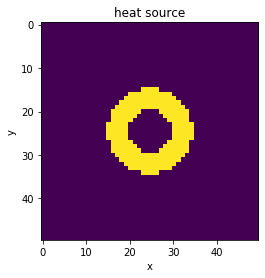

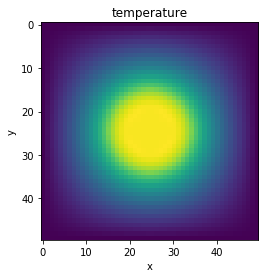

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot():
    
    nx = 50
    rho = np.zeros((nx, nx), dtype=np.float64)
    
    xx, yy = np.meshgrid(np.linspace(-1, 1, nx), np.linspace(-1, 1, nx))
    rho[:, :] = np.abs(np.sqrt(xx**2 + yy**2) - 0.3) < 0.1

    plt.figure()
    plt.imshow(rho)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("heat source")
    plt.show()

    n_iter=1000
            
    phi_numpy = np.zeros((nx, nx), dtype=np.float64)
    temperature_numpy(phi_numpy, rho, 1, 0.1, n_iter)
    
    plt.figure()
    plt.imshow(phi_numpy)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("temperature")
    plt.show()
    
plot()

# Test speed

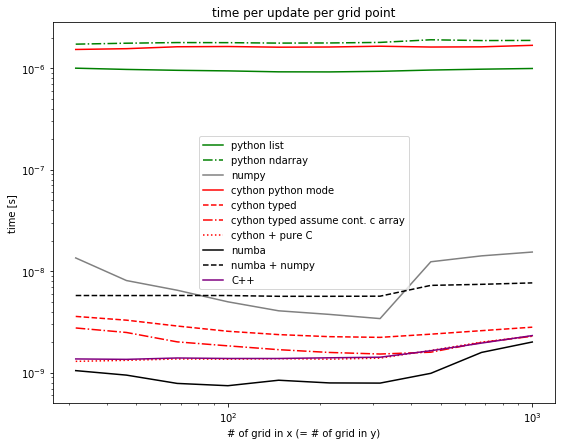

In [27]:
def plot_figure():

    ns = 10**np.linspace(1.5, 3, 10)
    ng = (ns - 2) * (ns - 2) * 1000

    a_python_list = [t.average for t in t_python_list]
    a_python_ndarray = [t.average for t in t_python_ndarray]
    a_numpy = [t.average for t in t_numpy]

    a_numba = [t.average for t in t_numba]
    a_numba_numpy = [t.average for t in t_numba_numpy]

    a_cython_python = [t.average for t in t_cython_python]
    a_cython_typed = [t.average for t in t_cython_typed]
    a_cython_optimzed = [t.average for t in t_cython_optimized]
    a_cython_c = [t.average for t in t_cython_c]

    a_cpp = [t.average for t in t_cpp]

    plt.figure(figsize=(9, 7))
    plt.yscale('log')
    plt.xscale('log')

    plt.plot(ns, a_python_list / ng * 1000, label="python list", color="green")
    plt.plot(ns,
             a_python_ndarray / ng * 1000,
             label="python ndarray",
             color="green",
             linestyle='-.')

    plt.plot(ns, a_numpy / ng, label="numpy", color="gray")

    plt.plot(ns,
             a_cython_python / ng * 1000,
             label="cython python mode",
             color="red")
    plt.plot(ns,
             a_cython_typed / ng,
             label="cython typed",
             color="red",
             linestyle='--')
    plt.plot(ns,
             a_cython_optimzed / ng,
             label="cython typed assume cont. c array",
             color="red",
             linestyle='-.')
    plt.plot(ns,
             a_cython_c / ng,
             label="cython + pure C",
             color="red",
             linestyle=':')

    plt.plot(ns, a_numba / ng, label="numba", color="black")
    plt.plot(ns,
             a_numba_numpy / ng,
             label="numba + numpy",
             color="black",
             linestyle="--")

    plt.plot(ns, a_cpp / ng, label="C++", color="purple")

    plt.xlabel("# of grid in x (= # of grid in y)")
    plt.ylabel("time [s]")
    #plt.ylim((5E-7, 5E-3))
    plt.legend()
    plt.title("time per update per grid point")
    plt.show()    


plot_figure()

## Discussion

### CPython

- CPython就是单纯的慢。CPython大多时间花费在了CPython的运行时上。而CPython运行时之所以慢是因为大多数时间用在了类型检查上。花费在单位格点上的时间和格点的数量无关，这是因为CPython运行时太慢了，运行总时间和cpu缓存等等基本没有关系。


- python使用list+`[]`会比numpy+`[]`更快。numpy是为矢量化操作优化的，对于这种频繁使用`[]`取出scalar的程序，性能会比使用原始Python list更慢。

### numpy

- numpy的性能是很不错的，与C/C++和cython相比，性能大概在一个数量级，但是慢了大概2-5倍。如果不自己写循环，numba对numpy没有加速。


### Cython
- Cython的纯python模式的速度和CPython的python模式的速度相近。Cython依然使用了CPython的运行时。Cython主要是节省了读取bytecode，解析bytecode的时间。而这一部分时间很少。大部分时间还是花费在了CPtyon的运行时上。


- 对带类型标记的cython：在Windows上，对连续数组的手动优化有用。在linux上，对连续数组的手动优化没有用。注意，无论是cython + C，还是纯C/C++代码都假定了数组是连续的C数组。所以为了公平起见，作比较的时候，我们应该和带类型标记的cython + 连续数组优化的情况相比。下文中，带类型标记的cython都是指做了连续数组优化的情况。


- 在Windows上，带类型标记的`cython`和`C/C++`相比，速度要慢，但是慢很少。在linux上，带类型的标记的`cython`和`C/C++`相比，速度要快。 两者从原理上看，前者是`cython`编译器生成的`C`代码，后者是用户自己写的。编译器对两种代码的优化能力可能有区别。


- `cython` + `C`和`C/C++`都是C/C++代码，所以性能应当一样快。在Windows上，两者速度几乎完全一样。在linux上cython + C要稍微慢一些。（代码是几乎一样的。性能有差异，可能是我使用了虚拟机的缘故。如果使用虚拟机，开启-march=native开关后，代码会变慢，而cython + C很可能使用了-march=native)


### numba
- `numba`对于所以格点数量都是最优秀的。`numba`的速度比没有做低阶优化的C/C++还要快。（对C/C++仔细调优后，可能结果会不一样）。但是随着格点数量增加，缓存速度成为速度瓶颈，无论是带类型标记cython,  C/C++还是numba速度都趋于相同。


# Some optimization

The algorithm used in speed test is not the optimal. Even for this algorithm, my code is not optimal. I will do some optimzation using numba. Note these optimzation can also used in other code.

## Pingpong

Eliminate the additional copy.

In [28]:
import numba

@numba.njit
def temperature_numba_algopt(phi, rho, alpha, dx, n_iter):

    phi_update = np.empty_like(phi)
    
    for it in range(n_iter//2):
        for i in range(1, phi.shape[0] - 1):
            for j in range(1, phi.shape[1] - 1):
                phi_update[i, j] = 0.25 * (phi[i - 1,j] + phi[i + 1,j]\
                    + phi[i, j - 1] + phi[i, j + 1])\
                    + dx*dx * rho[i, j]

        for i in range(1, phi.shape[0] - 1):
            for j in range(1, phi.shape[1] - 1):
                phi[i, j] = 0.25 * (phi_update[i - 1,j] + phi_update[i + 1,j]\
                    + phi_update[i, j - 1] + phi_update[i, j + 1])\
                    + dx*dx * rho[i, j]
                
    if n_iter%2:
        for i in range(1, phi.shape[0] - 1):
            for j in range(1, phi.shape[1] - 1):
                phi[i, j] = phi_update[i, j]      
                
            

## Backup one line

Cache friendly and stopp uncrolling the loop.

In [29]:
@numba.njit
def temperature_numba_algopt2(phi, rho, alpha, dx, n_iter):

    phi_backup = np.empty(phi.shape[1])

    for it in range(n_iter):

        for j in range(1, phi.shape[1] - 1):
            phi_backup[j] = phi[0, j]

        for i in range(1, phi.shape[0] - 1):

            for j in range(1, phi.shape[1] - 1):

                t = phi_backup[j]

                phi_backup[j] = phi[i, j]

                phi[i, j] = 0.25 * (t + phi[i + 1,j]\
                    + phi_backup[j-1] + phi[i, j + 1])\
                    + dx*dx * rho[i, j]

## An in-equivalent algorithm
uncrolling the loop.

In [30]:
@numba.njit
def temperature_numba_algopt3(phi, rho, alpha, dx, n_iter):

    for it in range(n_iter):
        for i in range(1, phi.shape[0] - 1):
            for j in range(1, phi.shape[1] - 1):
                phi[i, j] = 0.25 * (phi[i-1,j] + phi[i + 1,j]\
                    + phi[i, j - 1] + phi[i, j + 1])\
                    + dx*dx * rho[i, j]

In [31]:
import numba as nb
t_numba_algopt2=test_speed(temperature_numba_algopt2)
t_numba_algopt=test_speed(temperature_numba_algopt)
t_numba_algopt3=test_speed(temperature_numba_algopt3)

benchmarking: temperature_numba_algopt2
Average (    1 loops) time of     0.0011 s for 1000 updates on grid of 31x31
Average (  100 loops) time of     0.0025 s for 1000 updates on grid of 46x46
Average (  100 loops) time of     0.0052 s for 1000 updates on grid of 68x68
Average (  100 loops) time of     0.0118 s for 1000 updates on grid of 100x100
Average (   10 loops) time of     0.0254 s for 1000 updates on grid of 146x146
Average (   10 loops) time of     0.0547 s for 1000 updates on grid of 215x215
Average (   10 loops) time of     0.1185 s for 1000 updates on grid of 316x316
Average (    1 loops) time of     0.2570 s for 1000 updates on grid of 464x464
Average (    1 loops) time of     0.5920 s for 1000 updates on grid of 681x681
Average (    1 loops) time of     1.4269 s for 1000 updates on grid of 1000x1000
benchmarking: temperature_numba_algopt
Average (    1 loops) time of     0.0006 s for 1000 updates on grid of 31x31
Average ( 1000 loops) time of     0.0014 s for 1000 update

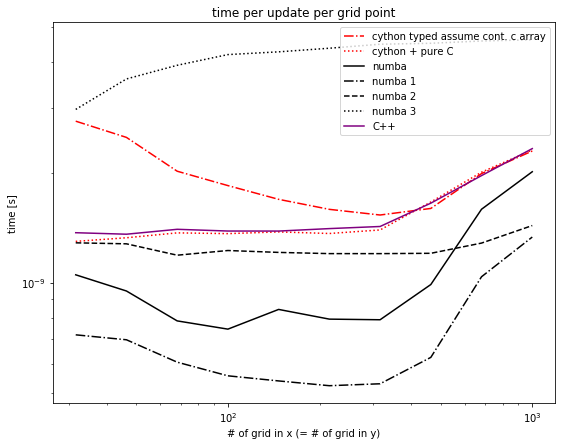

In [32]:
def plot_figure():

    ns = 10**np.linspace(1.5, 3, 10)
    ng = (ns - 2) * (ns - 2) * 1000

    a_numba = [t.average for t in t_numba]
    a_numba_algopt = [t.average for t in t_numba_algopt]
    a_numba_algopt2 = [t.average for t in t_numba_algopt2]
    a_numba_algopt3 = [t.average for t in t_numba_algopt3]

    a_cython_optimzed = [t.average for t in t_cython_optimized]
    a_cython_c = [t.average for t in t_cython_c]

    a_cpp = [t.average for t in t_cpp]

    plt.figure(figsize=(9, 7))
    plt.yscale('log')
    plt.xscale('log')

    plt.plot(ns,
             a_cython_optimzed / ng,
             label="cython typed assume cont. c array",
             color="red",
             linestyle='-.')
    plt.plot(ns,
             a_cython_c / ng,
             label="cython + pure C",
             color="red",
             linestyle=':')

    plt.plot(ns, a_numba / ng, label="numba", color="black")
    plt.plot(ns,
             a_numba_algopt / ng,
             label="numba 1",
             color="black",
             linestyle="-.")
    plt.plot(ns,
             a_numba_algopt2 / ng,
             label="numba 2",
             color="black",
             linestyle="--")
    plt.plot(ns,
             a_numba_algopt3 / ng,
             label="numba 3",
             color="black",
             linestyle=":")

    plt.plot(ns, a_cpp /     , label="C++", color="purple")

    plt.xlabel("# of grid in x (= # of grid in y)")
    plt.ylabel("time [s]")
    #plt.ylim((5E-7, 5E-3))
    plt.legend()
    plt.title("time per update per grid point")
    plt.show()


plot_figure()